In [ ]:
%%capture
!pip install transformers

In [ ]:
!pip install nlpaug

     |████████████████████████████████| 410 kB 4.4 MB/s 


In [ ]:
import pandas as pd
import os
import torch
import numpy as np
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from nlpaug.util import Action

#FIRST PARTICIPANT

# PREPROCESSING

In [ ]:
os.chdir('drive/MyDrive/William_2022')

In [ ]:
df = pd.read_csv('DATASETS/CSV/full_transcript_concat.csv')

In [ ]:
df

,new_words,seconds_trans,arousal_trans,valence_trans,happy_trans,angry_trans,nervous_trans,sad_trans,seconds2_trans,arousal2_trans,valence2_trans,happy2_trans,angry2_trans,nervous2_trans,sad2_trans
0,all right first one the state for this accepti...,5.0,1.333,2.667,1.667,1.0,1.333,1.0,5.0,3.000,2.667,1.333,1.000,1.667,1.0
1,arrived in this especially in many Arab Jesus ...,10.0,1.667,2.667,1.667,1.0,1.333,1.0,10.0,3.333,3.000,1.333,1.000,2.000,1.0
2,Jeju Allah first of all I want to mention that...,15.0,2.000,2.667,1.333,1.0,1.333,1.0,15.0,3.333,2.667,1.333,1.000,2.333,1.0
3,movement in South Korea against against this y...,20.0,2.000,3.000,1.333,1.0,1.333,1.0,20.0,3.667,2.667,1.333,1.000,2.333,1.0
4,pretty much standard phobic activity because,25.0,2.000,3.000,1.333,1.0,1.333,1.0,25.0,3.333,2.667,1.333,1.000,2.333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,The Courier what curse income,560.0,3.333,4.000,1.333,1.0,1.000,1.0,560.0,3.333,3.000,1.333,1.333,1.333,1.0
1859,cannot there with this issue and cannot,565.0,3.333,4.000,1.333,1.0,1.000,1.0,565.0,3.667,3.000,1.333,1.333,1.333,1.0
1860,change the no in this issue yeah,570.0,3.333,4.000,1.333,1.0,1.000,1.0,570.0,3.667,3.000,1.333,1.333,2.000,1.0
1861,your suggestion is very proper but there's no ...,575.0,3.333,4.000,1.333,1.0,1.000,1.0,575.0,3.333,3.000,1.333,1.333,2.000,1.0


In [ ]:
df['arousal_trans'] = df['arousal_trans'].round()
df['arousal2_trans'] = df['arousal2_trans'].round()

df['valence_trans'] = df['valence_trans'].round()
df['valence2_trans'] = df['valence2_trans'].round()

df['happy_trans'] = df['happy_trans'].round()
df['happy2_trans'] = df['happy2_trans'].round()

df['angry_trans'] = df['angry_trans'].round()
df['angry2_trans'] = df['angry2_trans'].round()

df['nervous_trans'] = df['nervous_trans'].round()
df['nervous2_trans'] = df['nervous2_trans'].round()

df['sad_trans'] = df['sad_trans'].round()
df['sad2_trans'] = df['sad2_trans'].round()

In [ ]:
df1 = df[['new_words', 'happy_trans']]

In [ ]:
df1['happy_trans'] = df1['happy_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 3:
    return 'high'
  else: 
    return 'very low'

df1['happy_trans'] = df.happy_trans.apply(to_emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
len(df1)

1863

In [ ]:
df1

,new_words,happy_trans
0,all right first one the state for this accepti...,low
1,arrived in this especially in many Arab Jesus ...,low
2,Jeju Allah first of all I want to mention that...,very low
3,movement in South Korea against against this y...,very low
4,pretty much standard phobic activity because,very low
...,...,...
1858,The Courier what curse income,very low
1859,cannot there with this issue and cannot,very low
1860,change the no in this issue yeah,very low
1861,your suggestion is very proper but there's no ...,very low


In [ ]:
df1['happy_trans'].value_counts()

very low    1231
low          608
high          24
Name: happy_trans, dtype: int64

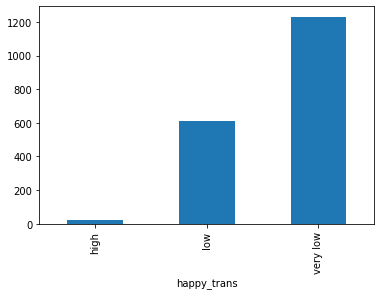

In [ ]:
df1.groupby(['happy_trans']).size().plot.bar()

In [ ]:
RANDOM_SEED = 41

df_train, df_test = train_test_split(
  df1,
  test_size=0.2,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
X_train = df_train['new_words']
y_train = df_train['happy_trans']

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)

In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [ ]:
augmented_sentences_0=[]
augmented_sentences_labels_0=[]
for i in X_train.index:
  if y_train[i]=='high':
    temps=aug.augment(X_train[i],n=50)
    for sent in temps:
      augmented_sentences_0.append(sent)
      augmented_sentences_labels_0.append('high')

In [ ]:
augmented_sentences_1=[]
augmented_sentences_labels_1=[]
for i in X_train.index:
  if y_train[i]=='low':
    temps=aug.augment(X_train[i],n=2)
    for sent in temps:
      augmented_sentences_1.append(sent)
      augmented_sentences_labels_1.append('low')

In [ ]:
from random import shuffle
shuffle(augmented_sentences_labels_1)
augmented_sentences_labels_1 = augmented_sentences_labels_1[:500]

shuffle(augmented_sentences_1)
augmented_sentences_1 = augmented_sentences_1[:500]

In [ ]:
X_train=X_train.append(pd.Series(augmented_sentences_1),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels_1),ignore_index=True)
X_train=X_train.append(pd.Series(augmented_sentences_0),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels_0),ignore_index=True)

In [ ]:
df_train = pd.concat([X_train, y_train], axis = 1)

In [ ]:
df_train.rename(columns={0:'new_words'},inplace=True)
df_train.rename(columns={1:'happy_trans'},inplace=True)

In [ ]:
df_train['happy_trans'].value_counts()

low         999
very low    972
high        969
Name: happy_trans, dtype: int64

In [ ]:
df_train.rename(columns={0:'new_words'},inplace=True)
df_train.rename(columns={1:'happy_trans'},inplace=True)
df1 = pd.concat([df_train,df_test,df_val])

In [ ]:
df1['happy_trans'].value_counts()

very low    1231
low         1108
high         974
Name: happy_trans, dtype: int64

# GET EMBEDDINGS

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

input_ids = []
attention_masks = []
for sentence in df1['new_words'].tolist():
    dictionary = tokenizer.encode_plus(
                        sentence,                      
                        add_special_tokens = True,
                        max_length = 32,
                        padding = 'max_length',
                        return_attention_mask = True,
                        
                        return_tensors = 'pt',
                   )
    # encode_plus returns a dictionary 
    input_ids.append(dictionary['input_ids'])
    attention_masks.append(dictionary['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
input_ids.shape

torch.Size([1863, 512])

In [ ]:
config = BertConfig.from_pretrained("bert-base-cased", output_hidden_states=True)
model = BertModel.from_pretrained("bert-base-cased", config=config)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

In [ ]:
embeddings = outputs[2][1:]

In [ ]:
def get_CLS_embedding(layer):
    return layer[:, 0, :].numpy()
    
cls_embeddings = []
for i in range(12):
    cls_embeddings.append(get_CLS_embedding(embeddings[i]))

In [ ]:
cls_embeddings[1]

array([[ 0.53212035,  0.05649804, -0.14431298, ...,  0.02656387,
        -0.01539803, -0.20540482],
       [ 0.41980353,  0.08978967, -0.1878395 , ...,  0.02888267,
        -0.02356468, -0.17520873],
       [ 0.45010602,  0.02404313, -0.19031654, ..., -0.00284378,
        -0.01476196, -0.22694337],
       ...,
       [ 0.46409288,  0.03884417, -0.1285164 , ...,  0.04464937,
        -0.00598468, -0.26997563],
       [ 0.45169583,  0.03831971, -0.11794426, ..., -0.03295819,
        -0.02130375, -0.17037155],
       [ 0.4086817 ,  0.05068026, -0.14322418, ...,  0.01346627,
         0.00841014, -0.38704818]], dtype=float32)

In [ ]:
df

#DOWNSTREAM TASK

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'very low' : 0,
    'low'      : 1,
    'high'     : 2
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['happy_trans']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 32, truncation=True,
                                return_tensors="pt") for text in df['new_words']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

np.random.seed(112)
df_train, df_val, df_test = np.split(df1.sample(frac=1, random_state=42), 
                                     [int(.8*len(df1)), int(.9*len(df1))])

print(len(df_train),len(df_val), len(df_test))

2650 331 332


In [ ]:
train

<function __main__.train>

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # sum = 980 + 493 + 17
    # weight = torch.tensor([980, 493, 17]) / sum
    # weights = {0:1.0, 1:2.0, 2:7.0}
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-4
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/208 [00:00<?, ?it/s]


IndexError: ignored

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)


Test Accuracy:  0.701


In [ ]:
torch.save(model.state_dict(), 'happy_model_weighted.bin')

In [ ]:
def predict(model, text):
  text_dict = tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
    mask = text_dict['attention_mask'].to(device)
    input_id = text_dict['input_ids'].squeeze(1).to(device)
    
    with torch.no_grad():
      output = model(input_id, mask)
      label_id = output.argmax(dim=1).item()
      for key in labels.keys():
        if labels[key] == label_id:
          print(text, ' => ',key, '#' ,label_id)
          break

model.eval()
predict(model, text='I am very happy')

I am very happy  =>  very low # 0


use training to predict and evalute error rate

try MSE

sparse categorical ce

In [ ]:
model = BertClassifier()
model.load_state_dict(torch.load('happy_model_weighted.bin'))
model.eval()

In [ ]:
df2 = df[['new_words', 'happy2_trans']]

In [ ]:
df2['happy2_trans'] = df2['happy2_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


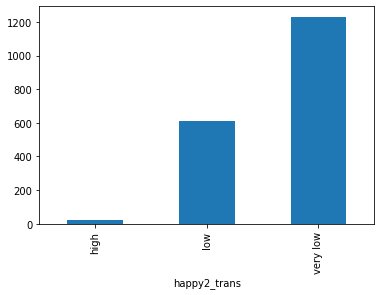

In [ ]:
df2.groupby(['happy2_trans']).size().plot.bar()

In [ ]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 3:
    return 'high'
  else: 
    return 'very low'

df2['happy2_trans'] = df.happy_trans.apply(to_emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'very low' : 0,
    'low'      : 1,
    'high'     : 2
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['happy2_trans']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['new_words']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

np.random.seed(112)
df_train, df_val, df_test = np.split(df2.sample(frac=1, random_state=42), 
                                     [int(.8*len(df2)), int(.9*len(df2))])

print(len(df_train),len(df_val), len(df_test))

1490 186 187


In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-4
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 1 | Train Loss:  0.394                 | Train Accuracy:  0.611                 | Val Loss:  0.409                 | Val Accuracy:  0.581


100%|██████████| 745/745 [01:41<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  0.379                 | Train Accuracy:  0.607                 | Val Loss:  0.390                 | Val Accuracy:  0.581


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 3 | Train Loss:  0.377                 | Train Accuracy:  0.599                 | Val Loss:  0.412                 | Val Accuracy:  0.602


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 4 | Train Loss:  0.370                 | Train Accuracy:  0.626                 | Val Loss:  0.396                 | Val Accuracy:  0.565


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 5 | Train Loss:  0.375                 | Train Accuracy:  0.619                 | Val Loss:  0.382                 | Val Accuracy:  0.634


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 6 | Train Loss:  0.371                 | Train Accuracy:  0.623                 | Val Loss:  0.396                 | Val Accuracy:  0.581


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 7 | Train Loss:  0.366                 | Train Accuracy:  0.616                 | Val Loss:  0.396                 | Val Accuracy:  0.624


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 8 | Train Loss:  0.367                 | Train Accuracy:  0.626                 | Val Loss:  0.385                 | Val Accuracy:  0.618


100%|██████████| 745/745 [01:40<00:00,  7.39it/s]


Epochs: 9 | Train Loss:  0.366                 | Train Accuracy:  0.630                 | Val Loss:  0.392                 | Val Accuracy:  0.640


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 10 | Train Loss:  0.359                 | Train Accuracy:  0.632                 | Val Loss:  0.377                 | Val Accuracy:  0.656


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 11 | Train Loss:  0.358                 | Train Accuracy:  0.641                 | Val Loss:  0.385                 | Val Accuracy:  0.651


100%|██████████| 745/745 [01:42<00:00,  7.30it/s]


Epochs: 12 | Train Loss:  0.355                 | Train Accuracy:  0.648                 | Val Loss:  0.383                 | Val Accuracy:  0.640


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 13 | Train Loss:  0.358                 | Train Accuracy:  0.646                 | Val Loss:  0.381                 | Val Accuracy:  0.624


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 14 | Train Loss:  0.359                 | Train Accuracy:  0.654                 | Val Loss:  0.397                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 15 | Train Loss:  0.356                 | Train Accuracy:  0.652                 | Val Loss:  0.374                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 16 | Train Loss:  0.353                 | Train Accuracy:  0.656                 | Val Loss:  0.372                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 17 | Train Loss:  0.353                 | Train Accuracy:  0.654                 | Val Loss:  0.374                 | Val Accuracy:  0.651


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 18 | Train Loss:  0.352                 | Train Accuracy:  0.656                 | Val Loss:  0.403                 | Val Accuracy:  0.468


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 19 | Train Loss:  0.351                 | Train Accuracy:  0.654                 | Val Loss:  0.378                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 20 | Train Loss:  0.354                 | Train Accuracy:  0.657                 | Val Loss:  0.384                 | Val Accuracy:  0.645


In [ ]:
torch.save(model.state_dict(), 'happy2_model.bin')

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)


Test Accuracy:  0.701


In [ ]:
model = BertClassifier()
model.load_state_dict(torch.load('happy2_model.bin'))
model.eval()

In [ ]:
def predict(model, text):
  text_dict = tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
    mask = text_dict['attention_mask'].to(device)
    input_id = text_dict['input_ids'].squeeze(1).to(device)
    
    with torch.no_grad():
      output = model(input_id, mask)
      label_id = output.argmax(dim=1).item()
      for key in labels.keys():
        if labels[key] == label_id:
          print(text, ' => ',key, '#' ,label_id)
          break

model.eval()
predict(model, text='I am SOOO EXCITED')

I am SOOO EXCITED  =>  very low # 0


In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])